## Abstract

This analysis explores the relationship between the average age of football clubs and their scoring performance.<br>
By integrating data from two datasets—one containing club information and the other detailing game outcomes —<br>
we aimed to determine if a club's average age influences its average goals scored.

Initially, we addressed missing age data by calculating the average age of players for clubs with unspecified ages.<br>
This was achieved by determining each player's age based on their date of birth and computing the average for each club.<br>
Subsequently, we merged this enriched club data with the game data, allowing us to attribute average age values<br>
to both home and away clubs for each match.

We then calculated the average goals scored by home and away clubs and combined these results to derive an overall<br>
average goals score for each club. Using this comprehensive dataset, we computed the Pearson correlation coefficient<br>
to measure the linear relationship between the average age of clubs and their average goals scored.

Our findings reveal a weak negative correlation (Pearson correlation coefficient of -0.11), indicating a slight tendency<br>
for older clubs to score fewer goals on average. This relationship, though present, is not strong enough to suggest a<br>
significant influence of average age on scoring performance.

The results are visualized through a scatter plot, illustrating the distribution and correlation between the two variables.<br>
This analysis provides a foundational understanding of the potential impact of club age demographics on performance,<br>
with implications for team management and strategy in football.

In [298]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import string
from datetime import datetime
plt.style.use('ggplot')


In [299]:
df_games = pd.read_csv('AssignmentData/games.csv')
df_club = pd.read_csv('AssignmentData/clubs.csv')

pd.set_option('display.max_columns', None) # Display all columns

### Data Cleaning for df_games

In [300]:
df_games = df_games[['game_id', 'competition_id', 'season', 'round', 'date', 'home_club_id',
       'away_club_id', 'home_club_goals', 'away_club_goals',
       'home_club_name',
       'away_club_name', 'aggregate']]

### Data Cleaning for df_club

In [301]:
df_club.columns

Index(['club_id', 'club_code', 'name', 'domestic_competition_id',
       'total_market_value', 'squad_size', 'average_age', 'foreigners_number',
       'foreigners_percentage', 'national_team_players', 'stadium_name',
       'stadium_seats', 'net_transfer_record', 'coach_name', 'last_season',
       'url'],
      dtype='object')

In [302]:
df_club = df_club[
['club_id', 'club_code', 'name', 'domestic_competition_id',
       'total_market_value', 'squad_size', 'average_age', 'foreigners_number',
       'foreigners_percentage', 'national_team_players', 'net_transfer_record', 'last_season']
]

### Rename columns to reflect total goals more clearly

In [303]:
df_games.rename(columns={"home_club_goals": "home_club_total_goals", "away_club_goals": "away_club_total_goals"}, inplace=True)

### Calculate the average age for club with NaN field


In [304]:
df_club_without_age = df_club[df_club['average_age'].isna()]

In [305]:
# Function to calculate age from date of birth
def calculate_age(date_of_birth):
    if pd.isna(date_of_birth):
        return None  # If the date of birth is NaN, it returns 'None'
    today = datetime(2024, 1, 1)  # Current date for age calculation. The age is calculated using January 1, 2024, as the current date.
    dob = datetime.strptime(str(date_of_birth), '%Y-%m-%d')# Convert date_of_birth to string before parsing
    age = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day)) # The age is computed by subtracting the birth year from the current year.
    #Adjust it if the birth date has not yet occurred in the current year.
    return age

# Filters the df_players DataFrame to include only those players who belong to clubs that don't have an average age recorded (df_club_without_age)
# isin() : This method checks if each player's current_club_id is in the list of club_ids from df_club_without_age.
filtered_player_df = df_players[df_players['current_club_id'].isin(df_club_without_age['club_id'])].copy()

# Apply the function to each player's date of birth
# A new age column is added to the filtered_player_df DataFrame with the calculated ages.
filtered_player_df['age'] = filtered_player_df['date_of_birth'].apply(calculate_age)

In [315]:
# Function to calculate average age of players for each club
def count_age(player_list):
    if player_list['age'].isnull().all():
        return 0  # Return 0 if all ages are NaN
    average_age = player_list['age'].mean() # Calculates the mean of the age column for the given player list.
    return average_age

# Calculate average age for each club and update df_club directly
df_club.loc[df_club['average_age'].isna(), 'average_age'] = (
    filtered_player_df.groupby('current_club_id') # The filtered_player_df DataFrame is grouped by current_club_id.
              .apply(count_age) # The count_age function is applied to each group to calculate the average age.
              .reindex(df_club.loc[df_club['average_age'].isna(), 'club_id']) # Align the calculated average ages of the players with the corresponding clubs that do not have an average age recorded.
              .round(1)  # Round average age to one decimal place
              .values
)

df_club[df_club['average_age'].isna()]

,club_id,club_code,name,domestic_competition_id,total_market_value,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,net_transfer_record,last_season


### Merge the club data with the games data for home and away clubs

In [307]:
df_home = df_games.merge(df_club[['club_id', 'average_age']], how='left', left_on='home_club_id', right_on='club_id') # Merging df_games with df_club on home_club_id (from df_games) and club_id (from df_club).
# The average_age from df_club is appended to each game in df_games where the home_club_id matches.
df_home = df_home.rename(columns={'average_age': 'home_club_average_age'}) # Rename column from 'average_age' to 'home_club_average_age'
df_away = df_games.merge(df_club[['club_id', 'average_age']], how='left', left_on='away_club_id', right_on='club_id') # Merges on away_club_id and club_id.
# The average_age from df_club is appended to each game in df_games where the away_club_id matches.
df_away = df_away.rename(columns={'average_age': 'away_club_average_age'})# Rename column from 'average_age' to 'away_club_average_age'

### Calculate the average scores for home and away clubs

In [308]:
home_scores = df_home.groupby('home_club_id').agg({'home_club_total_goals': 'mean', 'home_club_average_age': 'first'}).reset_index() # Calculates the mean of home_club_total_goals for each home club (average goals scored by the home club).
away_scores = df_away.groupby('away_club_id').agg({'away_club_total_goals': 'mean', 'away_club_average_age': 'first'}).reset_index() # Calculates the mean of away_club_total_goals for each away club (average goals scored by the away club).

### Combine home and away scores and ages into a single DataFrame

In [309]:
# Renames the columns in home_scores and away_scores to average_goals and average_age to standardize them for combining.
# Combines home_scores and away_scores into a single DataFrame combined_scores.g
home_scores = home_scores.rename(columns={'home_club_total_goals': 'average_goals', 'home_club_average_age': 'average_age'})
away_scores = away_scores.rename(columns={'away_club_total_goals': 'average_goals', 'away_club_average_age': 'average_age'})

In [310]:
combined_scores = pd.concat([home_scores, away_scores])

### Calculate the overall average scores and ages for each club

In [311]:
overall_scores = combined_scores.groupby('home_club_id').agg({'average_goals': 'mean', 'average_age': 'first'}).reset_index() # Groups combined_scores by home_club_id and calculates the mean of average_goals for each club.

### Calculate Pearson correlation coefficient

* This measures the linear relationship between the average age of clubs and their average goals scored.

In [316]:
# Calculates the mean of average_goals for each club.
correlation = overall_scores['average_age'].corr(overall_scores['average_goals'])
correlation

-0.11351521641857248

### Generate and Visualize the relationship in a scatter plot

* Creates a scatter plot with average_age on the x-axis and average_goals on the y-axis.

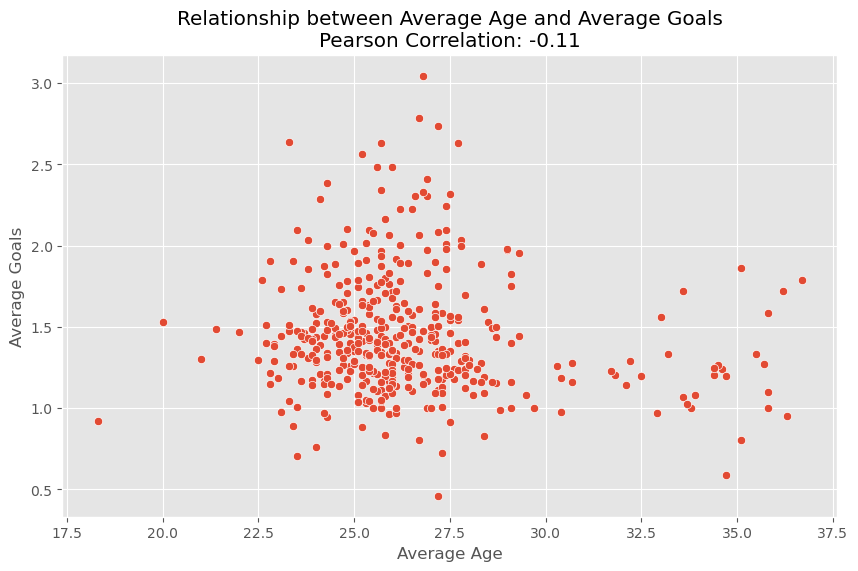

In [313]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='average_age', y='average_goals', data=overall_scores)
plt.title(f'Relationship between Average Age and Average Goals\nPearson Correlation: {correlation:.2f}')
plt.xlabel('Average Age')
plt.ylabel('Average Goals')
plt.grid(True)
plt.show()

<b>Strength of Correlation:</b> The absolute value of the correlation coefficient (0.1135)<br>
is less than 0.3, which generally indicates a weak correlation. This means that there is<br>
not a strong linear relationship between the average age of a team and its average<br>
goals scored.

<b>Negative Correlation:</b> The negative sign indicates the direction of the correlation.<br>
In this case, as the average age of a team increases, the average goals scored tend to<br>
slightly decrease, and vice versa. However, this relationship is weak.

<br>
<b>Conclusion</b><br>
In summary, a Pearson correlation coefficient of -0.1135 between average age and average<br>
goals indicates a weak negative relationship. It suggests that, on average, older teams<br>
may score slightly fewer goals than younger teams, but this association is not strong<br>
enough to make reliable predictions about goal-scoring based solely on team age.